In [51]:
import copy
import json
import math
import os
import pathlib
import time
import psycopg2
import requests
from requests.adapters import HTTPAdapter
from requests.auth import HTTPBasicAuth
from urllib3.util.retry import Retry

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from shapely.wkt import loads
from rasterio.mask import mask
import cv2

class PGConn:
    def __init__(self, host, port, dbname, user=None, passwd=None):
        self.host = host
        self.port = port
        self.dbname = dbname
        if user is not None:
            self.user = user
        else:
            self.user = ""
        if passwd is not None:
            self.passwd = passwd
        else:
            self.passwd = ""
        self.conn = None

    def connection(self):
        """Return connection to PostgreSQL.  It does not need to be closed
        explicitly.  See the destructor definition below.

        """
        if self.conn is None:
            conn = psycopg2.connect(dbname=self.dbname,
                                    host=self.host,
                                    port=str(self.port),
                                    user=self.user,
                                    password=self.passwd)
            self.conn = conn
            
        return self.conn

pgconn_obj = PGConn(
    "localhost",
    5432,
    "dolr",
    "sameer",
    "swimgood"
)
    
pgconn=pgconn_obj.connection()

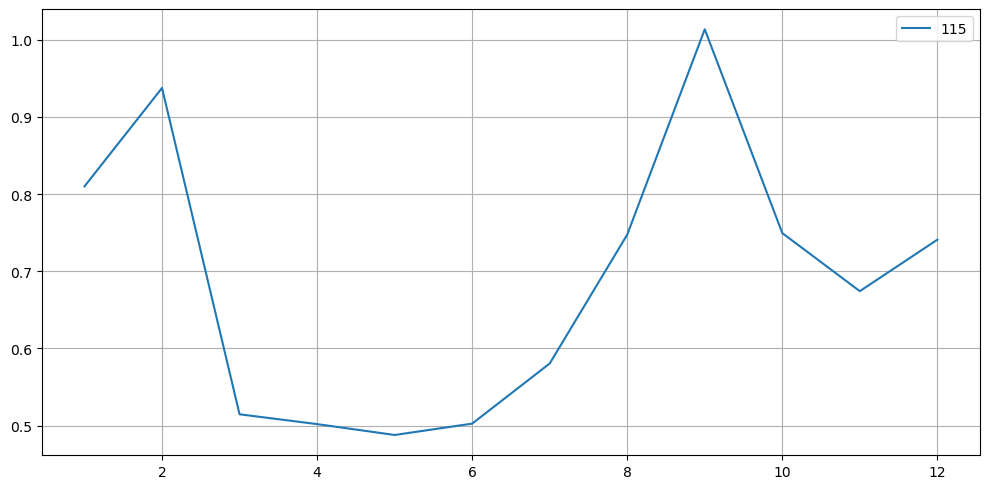

In [52]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
gids = [115]
results = {}
for gid in gids:
    results[gid] = []
    for month in months:
        query = f"""
        select
            red,
            green,
            blue,
            nir
        from
            pilot.{month}_cropping_pattern_dagdagad
        where
            gid = {gid}
        """
        with pgconn.cursor() as curs:
            curs.execute(query)
            rows = curs.fetchall()
        results[gid].append([float(item) for item in rows[0]])

fig = plt.figure(figsize=(10,5))
for gid in gids:
    greens = [item[1]/(item[0] + item[2]) for item in results[gid]]
    plt.plot(np.linspace(1, 12, num=12), greens, label=gid)
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

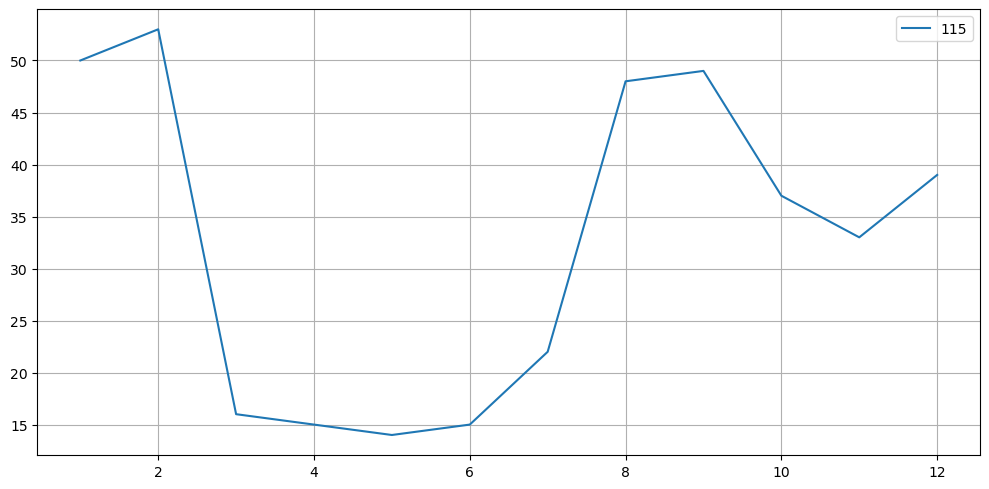

In [53]:
fig = plt.figure(figsize=(10,5))
for gid in gids:
    greens = [cv2.cvtColor(np.uint8([[[item[0], item[1], item[2]]]]), cv2.COLOR_RGB2HSV)[0][0][0] for item in results[gid]]
    plt.plot(np.linspace(1, 12, num=12), greens, label=gid)
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

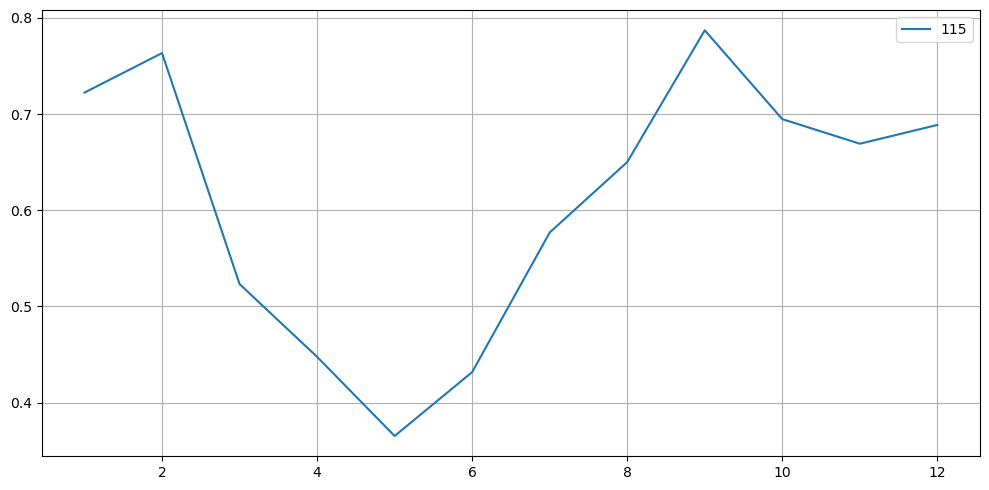

In [54]:
fig = plt.figure(figsize=(10,5))
for gid in gids:
    nvdi = [(item[3] - item[0])/(item[3] + item[0]) for item in results[gid]]
    plt.plot(np.linspace(1, 12, num=12), nvdi, label=gid)
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [55]:
def create_image_from_rgb(red, green, blue, geom, file_name):
    img = Image.new('RGB', (100, 100), (red, green, blue))    
    img.save(f"{file_name}.png")

months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
          'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
results = {}
for gid in [int(item) for item in np.linspace(1,200,num=200)]:
    results[gid] = []
    for month in months:
        query = f"""
        select
            red,
            green,
            blue,
            nir
        from
            pilot.{month}_cropping_pattern_dagdagad
        where
            gid = {gid}
        """
        with pgconn.cursor() as curs:
            curs.execute(query)
            rows = curs.fetchall()
        rgb_nir = [float(item) for item in rows[0]]
        results[gid].append(rgb_nir)

for gid in [int(item) for item in np.linspace(1,200,num=200)]:
    fig, axs = plt.subplots(4, 3, figsize=(12, 8))
    axs = axs.flatten()

    for i in range(12):
        axs[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=[float(v)/255.0 for v in results[gid][i]][0:3]))
        axs[i].set_title(f"{months[i]} r:{int(results[gid][i][0])}, g:{int(results[gid][i][1])}, b:{int(results[gid][i][2])}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.savefig(f"farmplot_timeseries/farm_{gid}.png")
    plt.close()

for gid in [int(item) for item in np.linspace(1,200,num=200)]:
    fig = plt.figure(figsize=(10,5))
    nvdi = [(item[3] - item[0])/(item[3] + item[0]) for item in results[gid]]
    plt.plot(np.linspace(1, 12, num=12), nvdi)
    plt.grid()
    plt.title(f"NVDI for gid = {gid}")
    plt.tight_layout()
    plt.savefig(f"farmplot_timeseries/nvdi_plot_{gid}.png")
    plt.close()